# Reverse MNIST with deconvolutional neural networks and PyTorch

A simple deconvolutional network to re-generate the convolutional network to re-generate MNIST digits using PyTorch.

In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision

amdgpu.ids: No such file or directory


## Setup GPU

Specific versions of PyTorch are needed depending on your system configuration.

* For GPU training on devices supporting using the ROCM backend, use `requirements/rocm.txt`
* For GPU training on devices supporting using the MPS backend (ie. Apple Metal), use `requirements/cpu.txt`
* For CPU training, use `requirements/cpu.txt`

In [2]:
if torch.cuda.is_available():
    backend = "cuda"
elif torch.backends.mps.is_available():
    backend = "mps"
else:
    backend = "cpu"

device = torch.device(backend)
device

device(type='cuda')

## Understand the convolution transposed operator

Before we begin, let us understand how the `ConvTranspose2d` operator
intuitively works. Set up a 2x2 kernel and see how it can 2x the spatial
dimensions of a 2x2 input.

Reference: [Apply a 2D Transposed Convolution Operation in PyTorch](https://www.geeksforgeeks.org/apply-a-2d-transposed-convolution-operation-in-pytorch/)

In [3]:
# Input
Input = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
# Kernel
Kernel = torch.tensor([[4.0, 1.0], [2.0, 3.0]])

# Redefine the shape in 4 dimension
Input = Input.reshape(1, 1, 2, 2)
Kernel = Kernel.reshape(1, 1, 2, 2)

# Transpose convolution Layer
Transpose = torch.nn.ConvTranspose2d(
    in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0, bias=False
)

# Initialize Kernel
Transpose.weight.data = Kernel

# Output value
Transpose(Input)

tensor([[[[ 0.,  0.,  4.,  1.],
          [ 0.,  0.,  2.,  3.],
          [ 8.,  2., 12.,  3.],
          [ 4.,  6.,  6.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [4]:
# Input
Input

tensor([[[[0., 1.],
          [2., 3.]]]])

## Define the model

Design a simple deconvolutional neural network with four layers.

- Layer 1 is a fully-connected layer that accepts a hot-one encoded digit, and expands it to 128 outputs
- Layer 2 is a fully-connected layer that accepts 128 inputs and expands it to a flat representation of a 7x7 image with 64 channels per pixel. The choice of a 7x7 image is because 7x2^2 is 28px, the original size of the MNIST image.
- Layer 3 is a deconvolutional layer that accepts an 7x7 image with 64 channels per pixel, and upsamples it to a 14x14 image with 32 channels per pixel
- Layer 4 is a deconvolutional layer that accepts an 14x14 image with 32 channels per pixel, and upsamples it to a 28x28 image with 1 channel per pixel

The arguments in `ConvTranspose2d` results in an exact doubling of the image dimensions. The resulting output size of the `ConvTranspose2d` operator is given by the formula:
    

$ \text{output\_size} = \text{strides} * (\text{input\_size}-1) + \text{kernel\_size} - 2*\text{padding} $

References:
* [Basic MNIST Example](https://github.com/pytorch/examples/blob/main/mnist/main.py)
* [reverse-mnist](https://github.com/fbleibel/reverse-mnist)
* [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic/tree/master)
* [Getting the output shape of deconvolution layer using tf.nn.conv2d_transpose in tensorflow](https://stackoverflow.com/questions/35980044/getting-the-output-shape-of-deconvolution-layer-using-tf-nn-conv2d-transpose-in)



In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Fully connected layers
        # - fc1 takes a one-hot array and expands it to 128 nodes
        # - fc2 takes the output of fc1 and expands it to an intermediate representation that is 7x7 pixels with 64 channels each
        #   - 7x7 is 1/4th the size of the final MNIST image
        self.fc1 = torch.nn.Linear(10, 128)
        self.fc2 = torch.nn.Linear(128, 7*7*64) 

        # Deconvolutional layers
        # - devonv1 takes a 7x7x64 intermediate represetnation and turns it into a 14x14x32 intermediate representation
        # - deconv2 takes a 14x14x32 intermediate representation and turns it into a 28x28x1 output
        self.deconv1 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)


    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x)) 
        x = torch.nn.functional.relu(self.fc2(x))
        x = x.view(-1, 64, 7, 7)  # Reshape to an n-length 7x7 grid of 64 channels
        x = torch.nn.functional.relu(self.deconv1(x))
        x = torch.nn.functional.sigmoid(self.deconv2(x))

        return x

In [6]:
model = Net().to(device)

## Load the MNIST data set

Use the built-in MNIST dataset from `torchvision`. The transformation are
normalized to the global mean and standard deviation of the dataset. Only the
training dataset is used in this example.

References: [PyTorch - Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=mnist)

In [7]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,)  # These are the global mean and standard deviations of the MNIST dataset
        ),
    ]
)

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

## Visualize an arbitrary image from the dataset

To gain an intuitive appreciation of the dataset, visualize a random digit. We
can now clearly see the 28x28 pixel greyscale representation of a handwritten
digit.

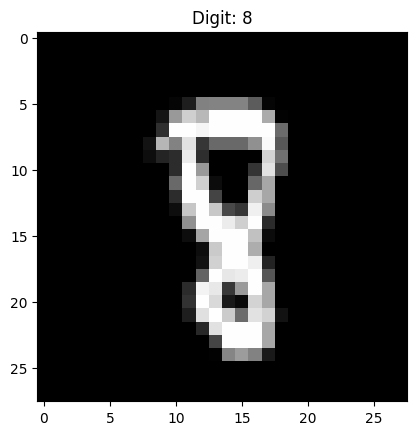

In [8]:
image, label = dataset[random.randint(0, len(dataset))]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Digit: {label}")
plt.show()

## Prepare the dataset

Split the dataset into our training and validation datasets. Here, we split 70%
of the data for training purposes.

Since I are using a dGPU to train, we set the batch size to something larger
than default. Adjust according to your hardware!

References: [Solving MNIST using PyTorch](https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch)

In [9]:
dataset_training_ratio = 0.70
dataset_length = len(dataset)
dataset_training_length = round(dataset_length * dataset_training_ratio)
dataset_validation_length = dataset_length - dataset_training_length

print(f"Total dataset count: {dataset_length}")
print(f"Training split ratio: {dataset_training_ratio}")
print(f"Training dataset count: {dataset_training_length}")
print(f"Validation dataset count: {dataset_validation_length}")

Total dataset count: 60000
Training split ratio: 0.7
Training dataset count: 42000
Validation dataset count: 18000


In [22]:
batch_size = 1024

training_data, validation_data = torch.utils.data.random_split(dataset, [dataset_training_length, dataset_validation_length])
training_loader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

## Training

We are now ready to set up our training loop. First we define the objective
function and the optimization algorithm we want to use in our learning loop.

Next, we define our training function. For every item in the training batch,
evaluate the model output given the training data and iterate the model
parameters in search of the objective.

The validation function is similar to the training function, negating any
optimization steps.

References:
* [Training with PyTorch](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
* [Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

In [27]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training function
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to GPU
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # One-hot encode the target labels
        target_one_hot = torch.eye(10, device=device)[target]
        output = model(target_one_hot)
        
        # Calculate loss
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 100 == 99:  # Print every 100 batches
            print(f'Epoch {epoch}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    # Disable gradient calculation to speed up computation
    with torch.no_grad():
        for data, target in val_loader:
            # Move data and target to GPU
            data, target = data.to(device), target.to(device)
            target_one_hot = torch.eye(10, device=device)[target]
            output = model(target_one_hot)
            loss = criterion(output, data)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch} Validation Loss: {val_loss:.4f}')

With the training and validation functions defined, we are now ready to train
our network. The training loop is configured to loop for three epochs.

In [28]:
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train(model, training_loader, criterion, optimizer, epoch)
    validate(model, validation_loader, criterion)

Epoch 1 Validation Loss: 0.7074
Epoch 2 Validation Loss: 0.7075
Epoch 3 Validation Loss: 0.7076
Epoch 4 Validation Loss: 0.7076
Epoch 5 Validation Loss: 0.7073


## Evaluate

Use the network to generate images for each digit to visualize the results of
the training.

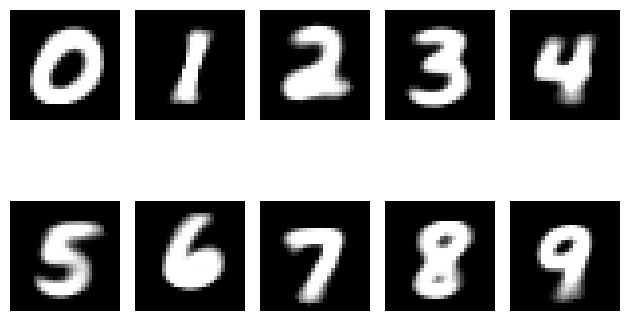

In [29]:
model.eval()
with torch.no_grad():
    one_hot_digits = torch.eye(10, device=device)
    generated_images = model(one_hot_digits)

# Move to CPU and squeeze
generated_images = generated_images.cpu().numpy().squeeze()

# Plot
fig, axes = plt.subplots(2, 5)
for i, img in enumerate(generated_images):
    ax = axes[i // 5, i % 5]
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

Just for fun, because we used one-hot encoding for each digit, we can also generate combination of digits!

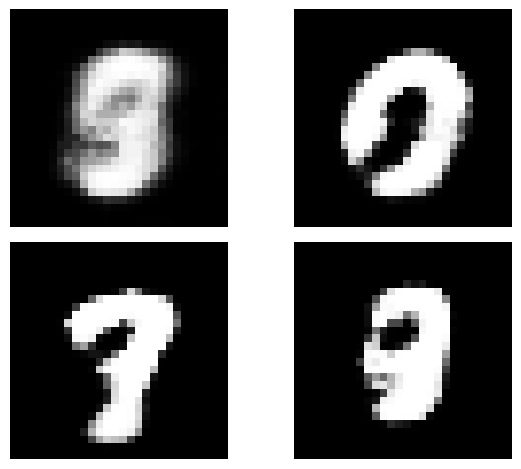

In [30]:
model.eval()
with torch.no_grad():
    one_hot_digits = torch.tensor(
        [
            [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # No digits
            [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],  # Combination of 1 and 9
            [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],  # Combination of 7., 8., 9
            [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],  # Combination of all digits
        ],
        device=device
    )
    generated_images = model(one_hot_digits)
    
# Move to CPU and squeeze
generated_images = generated_images.cpu().numpy().squeeze()

# Plot
fig, axes = plt.subplots(2, 2)
for i, img in enumerate(generated_images):
    ax = axes[i // 2, i % 2]
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()